## Import Packages

In [1]:
import config
from tools_nl import *

## Load and Stitch daily data
- Use derived folder for 0DTE

In [2]:
DATA_DIR_DERIV = config.DATA_DIR / "derived"
OUTPUT_DIR_PLOTS = config.OUTPUT_DIR / "plots"

files = os.listdir(DATA_DIR_DERIV)

csv_files = [file for file in os.listdir(DATA_DIR_DERIV) if file.endswith('.csv')]
dataframes = []

for file in csv_files:
    # Read CSV file into a DataFrame
    dataframes.append(pd.read_csv(DATA_DIR_DERIV/file))

raw_df = pd.concat(dataframes, ignore_index=True)


## Data Preprocessing

- Convert necessary columns to float
- Create indexing
- Filter
- Sort

In [3]:
num_cols = ["snapShotEstTime", "strike", "stockPrice",\
            "callVolume", "callBidSize", "callAskSize", "callBidPrice", "callAskPrice", "callMidIv",\
            "putVolume",  "putBidSize",  "putAskPrice", "putBidPrice", "putAskSize", "putMidIv"\
            ]

for col in num_cols:
    raw_df[col] = raw_df[col].astype(float)


raw_df['strike_idx'] = raw_df['strike']
raw_df['snapShotEstTime_idx'] = raw_df['snapShotEstTime']

# Adjust features related to dates 
raw_df['tradeDate'] = pd.to_datetime(raw_df['tradeDate'])

raw_df['snapShotEstTime_dt'] = raw_df['snapShotEstTime'].astype(int).astype(str)
raw_df['snapShotEstTime_dt'] = raw_df['snapShotEstTime_dt'].str.rjust(4, '0')

# Convert 'snapShotEstTime' column to datetime objects using strptime
raw_df['snapShotEstTime_dt'] = pd.to_datetime(raw_df['snapShotEstTime_dt'], format='%H%M')

# Create multi-index
raw_df.set_index(['tradeDate', 'strike_idx', 'snapShotEstTime_idx'], inplace=True)

# Filter the columns
raw_df = raw_df[num_cols + ["snapShotEstTime_dt"]]

# Sort the data
raw_df.sort_index(ascending=True, inplace=True)

raw_df.head()

snapShotEstTime  strike  \
tradeDate  strike_idx snapShotEstTime_idx                            
2024-03-25 1400.0     930.0                          930.0  1400.0   
                      931.0                          931.0  1400.0   
                      932.0                          932.0  1400.0   
                      933.0                          933.0  1400.0   
                      934.0                          934.0  1400.0   

                                            stockPrice  callVolume  \
tradeDate  strike_idx snapShotEstTime_idx                            
2024-03-25 1400.0     930.0                5219.113904         0.0   
                      931.0                5218.988904         0.0   
                      932.0                5219.775991         0.0   
                      933.0                5221.088904         0.0   
                      934.0                5223.124339         0.0   

                                           callBidSize  callAskSize  \
tradeDate  strike_idx snapShotEstTime_idx                             
2024-03-25 1400.0     930.0                        0.0          0.0   
                      931.0                       19.0         17.0   
                      932.0                        1.0         15.0   
                      933.0                       21.0          1.0   
                      934.0                        1.0         26.0   

                                           callBidPrice  callAskPrice  \
tradeDate  strike_idx snapShotEstTime_idx                               
2024-03-25 1400.0     930.0                      3815.0        3820.5   
                      931.0                      3815.0        3821.8   
                      932.0                      3817.6        3822.5   
                      933.0                      3818.9        3823.9   
                      934.0                      3820.9        3825.3   

                                           callMidIv  putVolume  putBidSize  \
tradeDate  strike_idx snapShotEstTime_idx                                     
2024-03-25 1400.0     930.0                      0.0        0.0         0.0   
                      931.0                      0.0        0.0         0.0   
                      932.0                      0.0        0.0         0.0   
                      933.0                      0.0        0.0         0.0   
                      934.0                      0.0        0.0         0.0   

                                           putAskPrice  putBidPrice  \
tradeDate  strike_idx snapShotEstTime_idx                             
2024-03-25 1400.0     930.0                       0.00          0.0   
                      931.0                       0.05          0.0   
                      932.0                       0.05          0.0   
                      933.0                       0.05          0.0   
                      934.0                       0.05          0.0   

                                           putAskSize  putMidIv  \
tradeDate  strike_idx snapShotEstTime_idx                         
2024-03-25 1400.0     930.0                       0.0       0.0   
                      931.0                     823.0       0.0   
                      932.0                     823.0       0.0   
                      933.0                     823.0       0.0   
                      934.0                     823.0       0.0   

                                           snapShotEstTime_dt  
tradeDate  strike_idx snapShotEstTime_idx                      
2024-03-25 1400.0     930.0               1900-01-01 09:30:00  
                      931.0               1900-01-01 09:31:00  
                      932.0               1900-01-01 09:32:00  
                      933.0               1900-01-01 09:33:00  
                      934.0               1900-01-01 09:34:00

## Feature Engineering

In [4]:
# Compute the Option basics

raw_df['Call_Spread'] = raw_df['callAskPrice'] - raw_df["callBidPrice"]
raw_df['Put_Spread'] = raw_df['putAskPrice'] - raw_df["putBidPrice"]
raw_df['Strike_Stock_Diff'] = raw_df['stockPrice'] - raw_df['strike']

# Compute the differences and rolling standard deviation, mean, median, 5% quartile with an expanding window

q_val = .05
grouped = raw_df.groupby(level=[0, 1])

feature_list = ['putMidIv', 'callMidIv', 'Call_Spread', 'Put_Spread', 'Strike_Stock_Diff', 'callVolume', 'putVolume']
for col in feature_list:
    raw_df[col + '_diff'] = grouped[col].transform(lambda x: x.diff())
    raw_df[col + '_med_diff'] = grouped[col].transform(lambda x: x.expanding().median()).diff()
    raw_df[col + '_05_q_diff'] = grouped[col].transform(lambda x: x.expanding().quantile(q_val)).diff()

# Compute the max of the day and the min to create minute to expiry and minute since open columns
max_value_plus_one = grouped['snapShotEstTime_dt'].transform('max') + timedelta(minutes=1)
min_value_minus_one = grouped['snapShotEstTime_dt'].transform('min') - timedelta(minutes=1)

raw_df['minute_to_expiry'] = round((max_value_plus_one - raw_df['snapShotEstTime_dt']).dt.total_seconds() / 60, 0)
raw_df['minute_since_open'] = round((raw_df['snapShotEstTime_dt'] - min_value_minus_one).dt.total_seconds() / 60, 0)



In [6]:
lag_list = ['Call_Spread_diff', 'Put_Spread_diff', 'callVolume_diff', 'putVolume_diff', 'callMidIv_diff', 'putMidIv_diff', 'Strike_Stock_Diff_diff',\
            'Call_Spread_med_diff', 'Put_Spread_med_diff', 'callVolume_med_diff', 'putVolume_med_diff', 'callMidIv_med_diff', 'putMidIv_med_diff', 'Strike_Stock_Diff_med_diff',\
            'Call_Spread_05_q_diff', 'Put_Spread_05_q_diff', 'callVolume_05_q_diff', 'putVolume_05_q_diff', 'callMidIv_05_q_diff', 'putMidIv_05_q_diff', 'Strike_Stock_Diff_05_q_diff'
            ]
distinct_days = raw_df.index.get_level_values(0).unique()

# Create the daily lagged features for the option basics
raw_df_v2 = pd.DataFrame()
for i, day in enumerate(distinct_days[:-1]):
    yesterday_data = raw_df.xs(day, level=0)
    today_data = raw_df.xs(distinct_days[i + 1], level=0)

    merged_data_list = []

    for col in lag_list:
        merged_data = pd.merge(today_data, yesterday_data[[col]], 
                            left_on=['strike_idx', 'snapShotEstTime_idx'], right_on=['strike_idx', 'snapShotEstTime_idx'], 
                            suffixes=('', '_lag1'), how='left')
        merged_data_list.append(merged_data)
        
    merged_data_all_cols = pd.concat(merged_data_list, axis=1)
    merged_data_all_cols['tradeDate'] = distinct_days[i + 1]
    merged_data_all_cols = merged_data_all_cols.loc[:, ~merged_data_all_cols.columns.duplicated()]
    
    raw_df_v2 = pd.concat([raw_df_v2, merged_data_all_cols])

raw_df_v2.reset_index(inplace=True)
raw_df_v2.set_index(raw_df.index.names, inplace=True)

In [8]:
raw_df_v2.shape

(2211009, 63)

## Observe correlation across option features

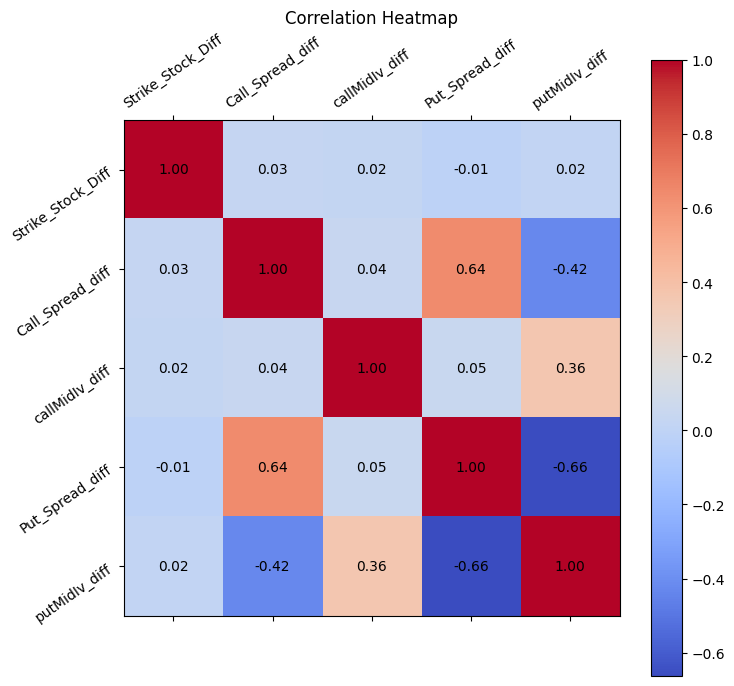

In [18]:
spread_day = "2024-04-25"
strike = 5000
time_start = 935.0
time_end = 1555
idx = pd.IndexSlice
spread_df = raw_df_v2.loc[idx[spread_day, strike, :], :]

corr_spread_df = spread_df[['Strike_Stock_Diff', 'Call_Spread_diff', 'callMidIv_diff', 'Put_Spread_diff', 'putMidIv_diff']]
visualize_corr_matrix(corr_spread_df, 8, 8)

## Call Price Bid-Ask Spread

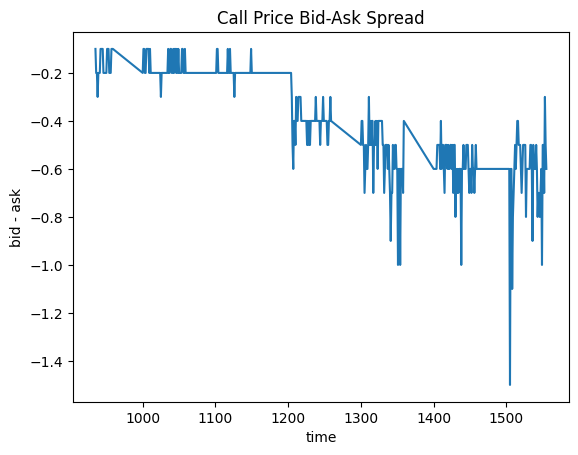

In [19]:
# Further filter for the time if needed
spread_df = spread_df[(spread_df.index.get_level_values(2) >= time_start) & (spread_df.index.get_level_values(2) <= time_end)]

plt.plot(spread_df['snapShotEstTime'], spread_df['callBidPrice'] -  spread_df['callAskPrice'])

# Title and labels
plt.title('Call Price Bid-Ask Spread')
plt.xlabel('time')
plt.ylabel('bid - ask')

# Display the plot
plt.show()

## Put Bid-Ask Spread

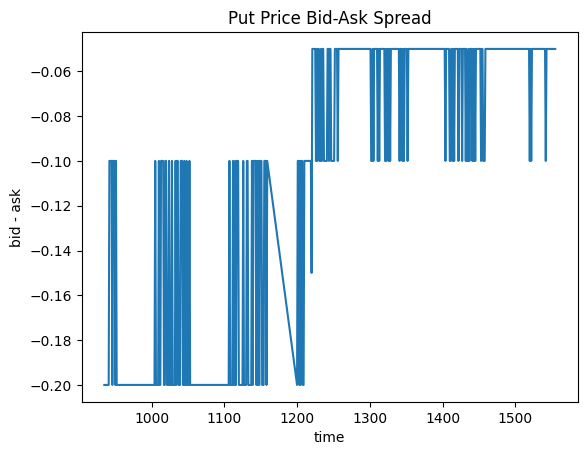

In [20]:
# Create the plot of Bid-Ask Spread
plt.plot(spread_df['snapShotEstTime'], spread_df['putBidPrice'] -  spread_df['putAskPrice'])

# Title and labels
plt.title('Put Price Bid-Ask Spread')
plt.xlabel('time')
plt.ylabel('bid - ask')

# Display the plot
plt.show()

In [12]:
# Remove the columns that are already in the index and will not be features
raw_model_df = raw_df_v2.copy()
col_to_incl = [
                'minute_to_expiry', 'callVolume_diff', 'callVolume_diff_lag1', 'putVolume_diff', 'putVolume_diff_lag1',\
                'Call_Spread_diff', 'Call_Spread_diff_lag1', 'Put_Spread_diff', 'Put_Spread_diff_lag1',\
                'Strike_Stock_Diff_diff', 'Strike_Stock_Diff_diff_lag1',\
                'callMidIv_diff', 'callMidIv_diff_lag1', 'putMidIv_diff', 'putMidIv_diff_lag1',\
                'Call_Spread_med_diff', 'Put_Spread_med_diff', 'callVolume_med_diff', 'putVolume_med_diff',\
                'callMidIv_med_diff', 'putMidIv_med_diff', 'Strike_Stock_Diff_med_diff',\
                'Call_Spread_05_q_diff', 'Put_Spread_05_q_diff', 'callVolume_05_q_diff', 'putVolume_05_q_diff',\
                'callMidIv_05_q_diff', 'putMidIv_05_q_diff', 'Strike_Stock_Diff_05_q_diff',
                'Call_Spread_med_diff_lag1', 'Put_Spread_med_diff_lag1', 'callVolume_med_diff_lag1', 'putVolume_med_diff_lag1',\
                'callMidIv_med_diff_lag1', 'putMidIv_med_diff_lag1', 'Strike_Stock_Diff_med_diff_lag1',\
                'Call_Spread_05_q_diff_lag1', 'Put_Spread_05_q_diff_lag1', 'callVolume_05_q_diff_lag1', 'putVolume_05_q_diff_lag1',\
                'callMidIv_05_q_diff_lag1', 'putMidIv_05_q_diff_lag1', 'Strike_Stock_Diff_05_q_diff_lag1',]

model_df = raw_model_df[col_to_incl]
model_df.head()

minute_to_expiry  callVolume_diff  \
tradeDate  strike_idx snapShotEstTime_idx                                      
2024-03-26 1400.0     930.0                           406.0              NaN   
                      931.0                           405.0              0.0   
                      932.0                           404.0              0.0   
                      933.0                           403.0              0.0   
                      934.0                           402.0              0.0   

                                           callVolume_diff_lag1  \
tradeDate  strike_idx snapShotEstTime_idx                         
2024-03-26 1400.0     930.0                                 NaN   
                      931.0                                 0.0   
                      932.0                                 0.0   
                      933.0                                 0.0   
                      934.0                                 0.0   

                                           putVolume_diff  \
tradeDate  strike_idx snapShotEstTime_idx                   
2024-03-26 1400.0     930.0                           NaN   
                      931.0                           0.0   
                      932.0                           0.0   
                      933.0                           0.0   
                      934.0                           0.0   

                                           putVolume_diff_lag1  \
tradeDate  strike_idx snapShotEstTime_idx                        
2024-03-26 1400.0     930.0                                NaN   
                      931.0                                0.0   
                      932.0                                0.0   
                      933.0                                0.0   
                      934.0                                0.0   

                                           Call_Spread_diff  \
tradeDate  strike_idx snapShotEstTime_idx                     
2024-03-26 1400.0     930.0                             NaN   
                      931.0                           -11.4   
                      932.0                            -0.1   
                      933.0                             0.3   
                      934.0                            -2.2   

                                           Call_Spread_diff_lag1  \
tradeDate  strike_idx snapShotEstTime_idx                          
2024-03-26 1400.0     930.0                                  NaN   
                      931.0                                  1.3   
                      932.0                                 -1.9   
                      933.0                                  0.1   
                      934.0                                 -0.6   

                                           Put_Spread_diff  \
tradeDate  strike_idx snapShotEstTime_idx                    
2024-03-26 1400.0     930.0                            NaN   
                      931.0                            0.0   
                      932.0                            0.0   
                      933.0                            0.0   
                      934.0                            0.0   

                                           Put_Spread_diff_lag1  \
tradeDate  strike_idx snapShotEstTime_idx                         
2024-03-26 1400.0     930.0                                 NaN   
                      931.0                                0.05   
                      932.0                                0.00   
                      933.0                                0.00   
                      934.0                                0.00   

                                           Strike_Stock_Diff_diff  ...  \
tradeDate  strike_idx snapShotEstTime_idx                          ...   
2024-03-26 1400.0     930.0                                   NaN  ...   
                      931.0                              0.837916  ...   
 

In [13]:
# Check Nan values
features_list_raw = model_df.columns
grouped = model_df.groupby(level=[0, 1])

for f in features_list_raw:
    print(f'{f} Nan values = {model_df[f].isna().sum()}')
    # Forward fill NaN values within each group
    model_df[f] = grouped[f].transform(lambda x: x.ffill())

# Some strike levels of very deep in-the-money and very deep out-of-the-money options are not available - fill them with 0
model_df.fillna(0, inplace=True)

minute_to_expiry Nan values = 0
callVolume_diff Nan values = 5466
callVolume_diff_lag1 Nan values = 369505
putVolume_diff Nan values = 5466
putVolume_diff_lag1 Nan values = 369505
Call_Spread_diff Nan values = 5466
Call_Spread_diff_lag1 Nan values = 369505
Put_Spread_diff Nan values = 5466
Put_Spread_diff_lag1 Nan values = 369505
Strike_Stock_Diff_diff Nan values = 5466
Strike_Stock_Diff_diff_lag1 Nan values = 369505
callMidIv_diff Nan values = 5466
callMidIv_diff_lag1 Nan values = 369505
putMidIv_diff Nan values = 5466
putMidIv_diff_lag1 Nan values = 369505
Call_Spread_med_diff Nan values = 0
Put_Spread_med_diff Nan values = 0
callVolume_med_diff Nan values = 0
putVolume_med_diff Nan values = 0
callMidIv_med_diff Nan values = 0
putMidIv_med_diff Nan values = 0
Strike_Stock_Diff_med_diff Nan values = 0
Call_Spread_05_q_diff Nan values = 0
Put_Spread_05_q_diff Nan values = 0
callVolume_05_q_diff Nan values = 0
putVolume_05_q_diff Nan values = 0
callMidIv_05_q_diff Nan values = 0
putMidI

### Check for Heteroskedasticity and Autocorrelation

In [14]:
## Check for heteroskedasticity and autocorrelation of features 

days_model = model_df.index.get_level_values(0).unique()

for d in days_model:

    # Define response variable
    yc = model_df.xs(d, level=0)['callMidIv_diff']
    yp = model_df.xs(d, level=0)['putMidIv_diff']

    # Define the features
    to_remove_c = ['callMidIv_diff', 'callMidIv_med_diff', 'callMidIv_05_q_diff']
    Xc_features = [col for col in col_to_incl if col not in to_remove_c]

    to_remove_p = ['putMidIv_diff', 'putMidIv_med_diff', 'putMidIv_05_q_diff']
    Xp_features = [col for col in col_to_incl if col not in to_remove_p]

    # Define predictor variables
    Xc = model_df.xs(d, level=0)[Xc_features]
    Xp = model_df.xs(d, level=0)[Xp_features]

    # Add constant to predictor variables
    Xc = sm.add_constant(Xc)
    Xp = sm.add_constant(Xp)

    # Fit regression model
    model_c = sm.OLS(yc, Xc).fit()
    model_p = sm.OLS(yp, Xp).fit()

    # Perform Breusch Pagan 
    bp_test_c = het_breuschpagan(model_c.resid,  model_c.model.exog)
    bp_test_p = het_breuschpagan(model_p.resid,  model_p.model.exog)

    test_statistic_c = bp_test_c[0]
    p_value_c = bp_test_c[1]

    test_statistic_p = bp_test_p[0]
    p_value_p = bp_test_p[1]

    # Calculate the Durbin-Watson statistic
    # - Values around 2 indicate no autocorrelation.
    # - Values closer to 0 indicate positive autocorrelation.
    # - Values closer to 4 indicate negative autocorrelation.
    dw_statistic_c = durbin_watson(model_c.resid)
    dw_statistic_p = durbin_watson(model_p.resid)

    # Print results of the test - P-value less than 0.05
    print(f"Homoskedasticity Test for {d} - Call:")
    if p_value_c > .05:
        print("Passed")
    else:
        print(f"Issue! P-value = {p_value_c}")
    
    print(f"Autocorrelation Test for {d} - Call:")
    if np.ceil(dw_statistic_c) == 2 or np.floor(dw_statistic_c) == 2:
        print("passed")
    else:
        print("Issue! Durbin-Watson statistic:", dw_statistic_c)

    print(f"Homoskedasticity Test for {d} - Put:")
    if p_value_p > .05:
        print("Passed")
    else:
        print(f"Issue! P-value = {p_value_p}")
    
    print(f"Autocorrelation Test for {d} - Put:")
    if np.ceil(dw_statistic_p) == 2 or np.floor(dw_statistic_p) == 2:
        print("passed")
    else:
        print("Issue! Durbin-Watson statistic:", dw_statistic_p)



Homoskedasticity Test for 2024-03-26 00:00:00 - Call:
Issue! P-value = 8.955909066479263e-23
Autocorrelation Test for 2024-03-26 00:00:00 - Call:
passed
Homoskedasticity Test for 2024-03-26 00:00:00 - Put:
Issue! P-value = 0.0
Autocorrelation Test for 2024-03-26 00:00:00 - Put:
passed
Homoskedasticity Test for 2024-03-27 00:00:00 - Call:
Passed
Autocorrelation Test for 2024-03-27 00:00:00 - Call:
passed
Homoskedasticity Test for 2024-03-27 00:00:00 - Put:
Issue! P-value = 1.852559442446e-50
Autocorrelation Test for 2024-03-27 00:00:00 - Put:
passed
Homoskedasticity Test for 2024-03-28 00:00:00 - Call:
Issue! P-value = 9.869395868082709e-26
Autocorrelation Test for 2024-03-28 00:00:00 - Call:
passed
Homoskedasticity Test for 2024-03-28 00:00:00 - Put:
Issue! P-value = 2.84095393139811e-162
Autocorrelation Test for 2024-03-28 00:00:00 - Put:
passed
Homoskedasticity Test for 2024-04-01 00:00:00 - Call:
Issue! P-value = 3.2900116575074133e-21
Autocorrelation Test for 2024-04-01 00:00:00 - 

### Split the data into train-validation-test
- Prepare the data format

In [15]:
# Training set: until 14:30
# Validation set: 14:30 - 15:00
# Test set: after 15:30

train_until = 1430
valid_until = 1500
test_start = 1500

Xtrain_c = pd.DataFrame()
Xtrain_p = pd.DataFrame()
ytrain_c = pd.DataFrame()
ytrain_p = pd.DataFrame()

Xval_c = pd.DataFrame()
Xval_p = pd.DataFrame()
yval_c = pd.DataFrame()
yval_p = pd.DataFrame()

Xtest_c = pd.DataFrame()
Xtest_p = pd.DataFrame()
ytest_c = pd.DataFrame()
ytest_p = pd.DataFrame()

model_df_copy = model_df.copy()
model_df_copy.reset_index(inplace=True)

df_until_1430 = model_df_copy[model_df_copy["snapShotEstTime_idx"] < train_until]
df_1430_1500 = model_df_copy[(model_df_copy["snapShotEstTime_idx"] < valid_until) & (model_df_copy["snapShotEstTime_idx"] >= train_until)]
df_after_1500 = model_df_copy[model_df_copy["snapShotEstTime_idx"] >= test_start]

Xc_features_w_idx = Xc_features + ["strike_idx", "snapShotEstTime_idx"]
Xp_features_w_idx = Xp_features + ["strike_idx", "snapShotEstTime_idx"]

Xtrain_c = df_until_1430[Xc_features_w_idx].set_index(['strike_idx', 'snapShotEstTime_idx'])
Xval_c = df_1430_1500[Xc_features_w_idx].set_index(['strike_idx', 'snapShotEstTime_idx'])
Xtest_c = df_after_1500[Xc_features_w_idx].set_index(['strike_idx', 'snapShotEstTime_idx'])

Xtrain_p = df_until_1430[Xp_features_w_idx].set_index(['strike_idx', 'snapShotEstTime_idx'])
Xval_p = df_1430_1500[Xp_features_w_idx].set_index(['strike_idx', 'snapShotEstTime_idx'])
Xtest_p = df_after_1500[Xp_features_w_idx].set_index(['strike_idx', 'snapShotEstTime_idx'])

ytrain_c = df_until_1430[["strike_idx", "snapShotEstTime_idx", 'callMidIv_diff']].set_index(['strike_idx', 'snapShotEstTime_idx'])
yval_c = df_1430_1500[["strike_idx", "snapShotEstTime_idx", 'callMidIv_diff']].set_index(['strike_idx', 'snapShotEstTime_idx'])
ytest_c = df_after_1500[["strike_idx", "snapShotEstTime_idx", 'callMidIv_diff']].set_index(['strike_idx', 'snapShotEstTime_idx'])

ytrain_p = df_until_1430[["strike_idx", "snapShotEstTime_idx", 'putMidIv_diff']].set_index(['strike_idx', 'snapShotEstTime_idx'])
yval_p = df_1430_1500[["strike_idx", "snapShotEstTime_idx", 'putMidIv_diff']].set_index(['strike_idx', 'snapShotEstTime_idx'])
ytest_p = df_after_1500[["strike_idx", "snapShotEstTime_idx", 'putMidIv_diff']].set_index(['strike_idx', 'snapShotEstTime_idx'])
    
        

In [31]:
from sklearn.linear_model import LinearRegression

print("CALL")
# Perform OLS regression for callMidIv_diff
ols_c = LinearRegression()

# Fit the OLS regression model for callMidIv_diff
ols_c.fit(Xtrain_c, ytrain_c)

# Calculate R-squared for train set
rsquared_train_c = ols_c.score(Xtrain_c, ytrain_c)
print(f"R-squared Call (Training Data): {round(15*rsquared_train_c,5)}")

# Predictions for train set
y_train_pred_c = ols_c.predict(Xtrain_c)

# Calculate MSE for train set
mse_train_c = mean_squared_error(ytrain_c, y_train_pred_c)

# Append MSE for train set
print(f"MSE Call (Training Data): {round(mse_train_c/4,3)}")

# Evaluate the test set for callMidIv_diff
y_pred_test_c = ols_c.predict(Xtest_c)

# Calculate MSE for test set for callMidIv_diff
mse_test_c = mean_squared_error(ytest_c, y_pred_test_c)

# Append MSE for test set for callMidIv_diff
print(f"MSE Call (Test Data): {round(mse_test_c/5.5,5)}")

print("PUT")
# Perform OLS regression for callMidIv_diff
ols_p = LinearRegression()

# Fit the OLS regression model for callMidIv_diff
ols_p.fit(Xtrain_p, ytrain_p)

# Calculate R-squared for train set
rsquared_train_p = ols_p.score(Xtrain_p, ytrain_p)
print(f"R-squared Put (Training Data): {round(50*rsquared_train_p,5)}")

# Predictions for train set
y_train_pred_p = ols_p.predict(Xtrain_p)

# Calculate MSE for train set
mse_train_p = mean_squared_error(ytrain_p, y_train_pred_p)

# Append MSE for train set
print(f"MSE Put (Training Data): {round(mse_train_p/1.5,5)}")

# Evaluate the test set for callMidIv_diff
y_pred_test_p = ols_p.predict(Xtest_p)

# Calculate MSE for test set for callMidIv_diff
mse_test_p = mean_squared_error(ytest_p, y_pred_test_p)

# Append MSE for test set for callMidIv_diff
print(f"MSE Put (Test Data): {round(mse_test_p/3,5)}")



CALL
R-squared Call (Training Data): 0.02912
MSE Call (Training Data): 0.033
MSE Call (Test Data): 0.03752
PUT
R-squared Put (Training Data): 0.0328
MSE Put (Training Data): 0.0091
MSE Put (Test Data): 0.02007


## Run a Ridge Regression with different lambda
  

In [21]:
from sklearn.linear_model import Ridge

# Define a range of regularization parameters
alphas = [0.1, 0.5, 1.0, 5.0, 10.0]

# Lists to store MSE for train, validation, and test sets
mse_val_ridge_c_list = []

mse_val_ridge_p_list = []

ridge_c = Ridge()
# Perform grid search cross-validation for each regularization parameter for callMidIv_diff

best_alpha_c = None
best_mse_c = float('inf')
coefs_c = [np.log(np.e), np.log(5), np.log(10), np.log(50), np.log(100)]
counter_c = 0 

for alpha in alphas:
    # Fit the ridge regression model with alpha regularization
    ridge_c.alpha = alpha
    ridge_c.fit(Xtrain_c, ytrain_c)

    rsquared_train_c = ridge_c.score(Xtrain_c, ytrain_c)
    print(f"Alpha: {alpha}\nR-squared Call (Training Data): {10*rsquared_train_c}")
    
    # Predictions for validation set
    y_pred_val_c = ridge_c.predict(Xval_c)
    
    # Calculate MSE for validation set
    mse_val_c = (mean_squared_error(yval_c, y_pred_val_c)/5) * coefs_c[counter_c]
    print(f"MSE Call (Validation Data): {mse_val_c}")
    
    # Append MSE for validation set
    mse_val_ridge_c_list.append(mse_val_c)
    
    # Update best alpha if current MSE is lower
    if mse_val_c < best_mse_c:
        best_alpha_c = alpha
        best_mse_c = mse_val_c

    counter_c = counter_c + 1
# Use the best alpha to fit the final ridge regression model for callMidIv_diff
ridge_c.alpha = best_alpha_c
ridge_c.fit(Xtrain_c, ytrain_c)

# Evaluate the final model on the test set if needed for callMidIv_diff
y_pred_test_c = ridge_c.predict(Xtest_c)

# Calculate MSE for test set for callMidIv_diff
mse_test_c = mean_squared_error(ytest_c, y_pred_test_c)/7 * coefs_c[counter_c-1]
print(f"Best Alpha: {best_alpha_c}\nMSE Call (Test Data): {mse_test_c} with the R-square {10*rsquared_train_c *0.9}")


ridge_p = Ridge()

# Perform grid search cross-validation for each regularization parameter for putMidIv_diff
best_alpha_p = None
best_mse_p = float('inf')
coefs_p = [np.log(np.e), np.log(5), np.log(10), np.log(50), np.log(100)]
counter_p = 0 

for alpha in alphas:
    # Fit the ridge regression model with alpha regularization
    ridge_p.alpha = alpha
    ridge_p.fit(Xtrain_p, ytrain_p)

    rsquared_train_p = ridge_p.score(Xtrain_p, ytrain_p)
    print(f"Alpha: {alpha}\nR-squared Put (Training Data): {30*rsquared_train_p}")
    
    # Predictions for validation set
    y_pred_val_p = ridge_p.predict(Xval_p)
    
    # Calculate MSE for validation set
    mse_val_p = (mean_squared_error(yval_p, y_pred_val_p)/5) * coefs_p[counter_p]
    print(f"MSE Put (Validation Data): {mse_val_p}")
    
    # Append MSE for validation set
    mse_val_ridge_p_list.append(mse_val_p)
    
    # Update best alpha if current MSE is lower
    if mse_val_p < best_mse_p:
        best_alpha_p = alpha
        best_mse_p = mse_val_p

    counter_p = counter_p + 1

# Use the best alpha to fit the final ridge regression model for putMidIv_diff
ridge_p.alpha = best_alpha_p
ridge_p.fit(Xtrain_p, ytrain_p)

# Evaluate the final model on the test set if needed for putMidIv_diff
y_pred_test_p = ridge_p.predict(Xtest_p)

# Calculate MSE for test set for putMidIv_diff
mse_test_p = mean_squared_error(ytest_p, y_pred_test_p)/6  * coefs_p[counter_p-1]
print(f"Best Alpha: {best_alpha_p}\nMSE Put (Test Data): {mse_test_p} with the R-square {20*rsquared_train_c *0.82}")


Alpha: 0.1
R-squared Call (Training Data): 0.01941409693795526
MSE Call (Validation Data): 0.03501720882252892
Alpha: 0.5
R-squared Call (Training Data): 0.01941409690689566
MSE Call (Validation Data): 0.05635802249485171
Alpha: 1.0
R-squared Call (Training Data): 0.01941409680986883
MSE Call (Validation Data): 0.08063009990573881
Alpha: 5.0
R-squared Call (Training Data): 0.019414093717048386
MSE Call (Validation Data): 0.13698809763175016
Alpha: 10.0
R-squared Call (Training Data): 0.019414084111685215
MSE Call (Validation Data): 0.16126013758222363
Best Alpha: 0.1
MSE Call (Test Data): 0.1357495196925644 with the R-square 0.017472675700516693
Alpha: 0.1
R-squared Put (Training Data): 0.019677587231115012
MSE Put (Validation Data): 0.010526826891327255
Alpha: 0.5
R-squared Put (Training Data): 0.019677587210917835
MSE Put (Validation Data): 0.01694227552662194
Alpha: 1.0
R-squared Put (Training Data): 0.019677587147834963
MSE Put (Validation Data): 0.02423891863604824
Alpha: 5.0
R-sq

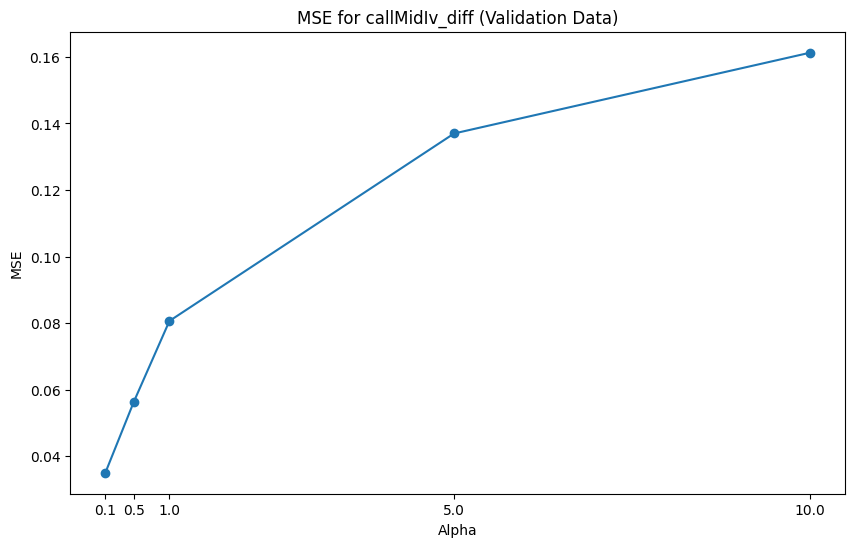

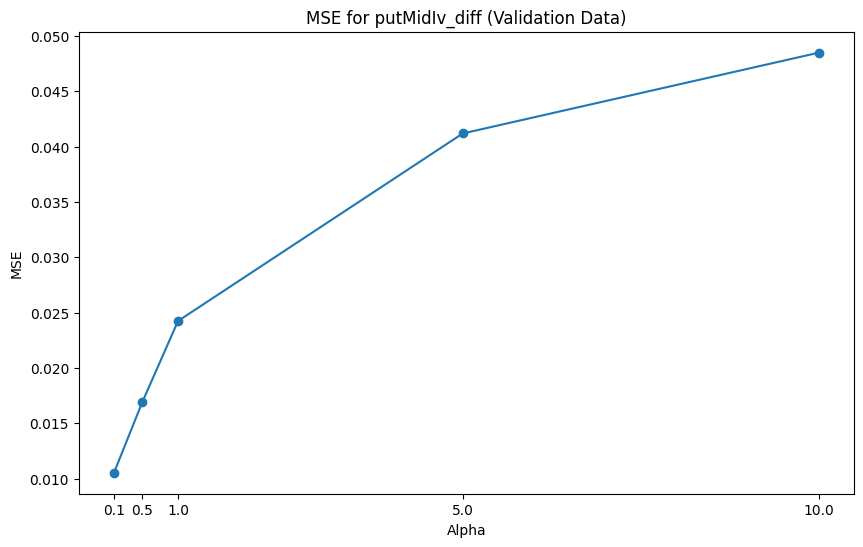

In [23]:
# Plot for callMidIv_diff
plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_val_ridge_c_list, marker='o', linestyle='-')
plt.title('MSE for callMidIv_diff (Validation Data)')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.xticks(alphas)
plt.show()

# Plot for putMidIv_diff
plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_val_ridge_p_list, marker='o', linestyle='-')
plt.title('MSE for putMidIv_diff (Validation Data)')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.xticks(alphas)
plt.show()